# by Andy Jiménez

## Imports

In [0]:
import numpy as np
from numpy.random import rand
from numpy import vstack,array
from pandas_datareader import data as web
import pandas as pd
from pylab import plot,show
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy import stats
import seaborn as sns

sns.set(style="whitegrid")

## Stock Index

In [0]:
sp500_wiki = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

sp = pd.read_html(sp500_wiki)
sp = sp[0]['Symbol'].tolist()
print('No. Stocks: ',len(sp))

## Historical Data

In [0]:
# Get historical Data for each stock of SP500

sp500_stocks = []
for stock in sp:
    try:
        close_prices = web.DataReader(stock,'yahoo','01/01/2019')['Adj Close']
        close_prices = pd.DataFrame(close_prices)
        close_prices.columns = [stock]
        sp500_stocks.append(close_prices)
    except:
        pass
    df = pd.concat(sp500_stocks,axis=1)
    df.sort_index(inplace=True)

df.head(2)

In [0]:
# Annualized Returns and Volatilities
ret = df.pct_change().mean()* 252
ret = pd.DataFrame(ret)
ret.columns = ['Returns']
ret['Volatility'] = df.pct_change().std() * np.sqrt(252)

ret.tail(2)

In [0]:
data = np.asarray([np.asarray(ret['Returns']),np.asarray(ret['Volatility'])]).T
data

## Elbow Curve

In [0]:
# Elbow Curve to Find the Optimal number of clusters

x = data
distorsions = []
for i in range(2, 20):
    k_means = KMeans(n_clusters=i)
    k_means.fit(x)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve', fontsize=16)
plt.xlabel('No. Clusters')
plt.ylabel('Sum of Square Error within Clusters');

## Outliers

In [0]:
# Identifying Outliers: Z-Score
z = np.abs(stats.zscore(ret))
print(z)

[[0.65817816 0.72402003]
 [0.52325598 0.84873124]
 [0.112058   0.72101935]
 ...
 [0.18318992 0.39605373]
 [0.91313389 0.58136614]
 [0.91858052 0.72495043]]


In [0]:
# Identifying Z-score values greater than 3 (3σ Approach)
print(np.where(z > 3))

(array([ 21,  46,  88,  88, 158, 238, 349, 360]), array([0, 1, 0, 1, 1, 0, 1, 1]))


In [0]:
ret.iloc[88]

Returns       3.526023
Volatility    1.752382
Name: CARR, dtype: float64

In [246]:
# Original dataframe
ret.shape

(503, 2)

In [0]:
# Remove Outliers from dataframe
ret_outliers = ret[(z<3).all(axis=1)]

In [0]:
# Afeter removing Outliers
ret_outliers.shape

(496, 2)

## Plotting Clusters

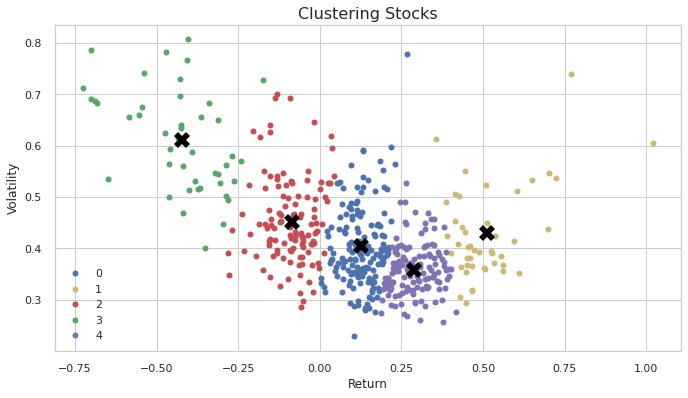

In [0]:
# Feed data into the algorithm
data = np.asarray([np.asarray(ret_outliers['Returns']),np.asarray(ret_outliers['Volatility'])]).T

# computing K-Means with K = 5
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

# some plotting using numpy's logical indexing
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(data[idx==0,0],data[idx==0,1],'ob', 
     data[idx==1,0],data[idx==1,1],'oy', 
     data[idx==2,0],data[idx==2,1],'or', 
     data[idx==3,0],data[idx==3,1],'og', 
     data[idx==4,0],data[idx==4,1],'om')
ax.plot(centroids[:,0],centroids[:,1],'X',markersize=16, c='black')
plt.legend('01234',loc = 'lower left' )
plt.xlabel('Return')
plt.ylabel('Volatility')
plt.title('Clustering Stocks', fontsize=16)
show()

In [0]:
# Details of which stock is actually in which cluster
details = [(ticker,cluster) for ticker, cluster in zip(ret_outliers.index,idx)]

clusters = pd.DataFrame(details, columns=['Symbol','Cluster'])
clusters.set_index('Symbol').tail(2)

,Cluster
Symbol,
ZION,2
ZTS,4


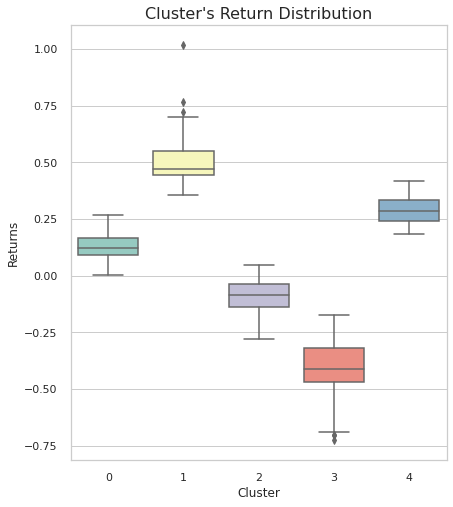

In [0]:
# Describing Cluster's Return
dfo = ret.merge(clusters,left_index=True, right_on='Symbol')

fig,ax = plt.subplots(figsize=(6,8))

ax = sns.boxplot(x="Cluster", y="Returns",
                 data=dfo, palette="Set3")
plt.title("Cluster's Return Distribution", fontsize=16);


## Detecting Outliers in the Returns of Single Stock

In [0]:
df2 = pd.DataFrame(web.DataReader('AAPL','yahoo','01/01/2017')['Adj Close'])

window = 21

df2['daily_ret'] = df2.pct_change()

df_rolling = df2[['daily_ret']].rolling(window=window).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_rolling.tail(2)

,mean,std
Date,,
2020-04-13,0.006123,0.056867
2020-04-14,0.002823,0.051718


In [0]:
df_outliers = df2.join(df_rolling)
df_outliers.rename(columns={'mean':'mean w='+str(window),'std':'std w='+str(window)}, inplace=True)
df_outliers.tail(2)

,Adj Close,daily_ret,mean w=21,std w=21
Date,,,,
2020-04-13,273.250000,0.019628,0.006123,0.056867
2020-04-14,287.049988,0.050503,0.002823,0.051718


In [0]:
# Function to Identify Outliers
def identify_outliers(row, n_sigmas=3):
  x = row['daily_ret']
  mu = row['mean w='+str(window)]
  sigma = row['std w='+str(window)]
  if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
    return 1
  else:
    return 0

In [0]:
# Apply Function
df_outliers['outlier'] = df_outliers.apply(identify_outliers, axis=1)

# Identify Outliers and get their daily return
outliers = df_outliers.loc[df_outliers['outlier'] == 1,['daily_ret']]

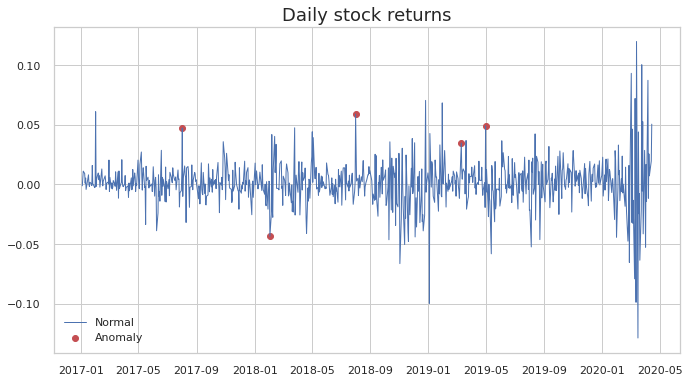

In [0]:
# Plot Outliers
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_outliers.index,df_outliers.daily_ret,c='b',label='Normal', lw=1)
ax.scatter(outliers.index,outliers.daily_ret,c='r',label='Anomaly')
ax.set_title("Daily stock returns", fontsize=18)
ax.legend(loc='lower left');